# Tutorial 1

In this notebook we will try to simply augment the size of given training sets. Using the pre-defined functions of pyraug.

## Example 1: MNIST - Training from `numpy.array` or `torch.tensor`

### Data extraction

In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

True

#### Extract the data
We only selected 200 samples and display some of the training samples

In [2]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)

In [3]:
n_samples = 200
dataset_to_augment = mnist_trainset.data[:n_samples] 
dataset_to_augment.shape

torch.Size([200, 28, 28])

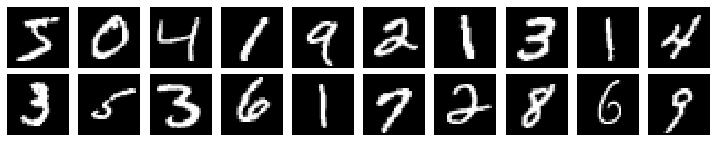

In [4]:
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(2):
        for j in range(10):
                axes[i][j].matshow(dataset_to_augment[i*10 +j].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)
#plt.savefig('plots/training_data_3_rotated_corrupted.pdf')

## Let's augment them !

## Step 1 - Model training

The first thing to do to augment your data is to train a generative model on it. The you wil be able to reuse such model to generate as much data as desired to augment your initial data set.

In [5]:
from pyraug.trainers.training_config import TrainingConfig
from pyraug.pipelines.training import TrainingPipeline
from pyraug.data import *

Here we define a training configuration that will be passed to the `TrainingPipeline`.

In [6]:
config = TrainingConfig(
    output_dir='my_model',
    train_early_stopping=50,
    learning_rate=1e-3,
    batch_size=200, # SetSet to 200 for demo purposes to speed up (default: 50)
    max_epochs=200 # Set to 200 for demo purposes. Augment this in your case (default: 20000)
)

Let's create and launch the Pipeline on our data! You will be able to follow th training evolution in the `output_logs` folder. 

In [7]:
torch.manual_seed(8)
pipeline = TrainingPipeline(training_config=config)
pipeline(train_data=dataset_to_augment, log_output_dir='output_logs')

Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None
Created my_model folder since did not exist.
Model passed sanity check !

Created my_model/training_2021-06-29_15-50-41. 
Training config, checkpoints and final model will be saved here.

Created output_logs folder since did not exists. Training logs will be recodered here.

Successfully launched training !
----------------------------------
Training ended!
Saved final model in my_model/training_2021-06-29_15-50-41/final_model


## Step 2 - Generate new data from your trained model

Next, just reload the model and pass it to the `GenerationPipeline` 

In [8]:
from pyraug.pipelines.generation import GenerationPipeline

In [9]:
last_training = sorted(os.listdir('my_model'))[-1]
print(last_training)

training_2021-06-29_15-50-41


In [10]:
from pyraug.models import RHVAE
from pyraug.models.rhvae import RHVAESamplerConfig

model = RHVAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

Let's create and launch the Pipeline with our model!

In [11]:
generation_pipe = GenerationPipeline(
    model=model
)

Created dummy_output_dir folder since did not exist.



In [12]:
generation_pipe(100)

Created dummy_output_dir/generation_2021-06-29_15-51-19.Generated data and sampler config will be saved here.

Generation successfully launched !



In [13]:
last_generation = sorted(os.listdir('dummy_output_dir'))[-1]
print(last_generation)

generation_2021-06-29_15-51-19


## Step 3 - Retrieve the generated data

In [14]:
generated_data = torch.load(os.path.join('dummy_output_dir', last_generation, 'generated_data_100_0.pt'))

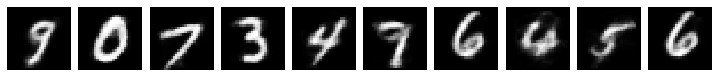

In [15]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 0
for i in range(10):
        
                axes[i].matshow(generated_data[i].cpu().reshape(28, 28).numpy(), cmap='gray')
                axes[i].axis('off')

plt.tight_layout(pad=0.8)

Here the model may need more training. We deliberatly stop training after 200 epochs. To see better performances, try augmentating the `max_epochs` argument of the `TrainingConfig`.

## Example 2: Custom data - Training from folder

In [43]:
from PIL import Image

path_to_images = '../data/misc/cat'

Let's have a look to the images in this folder

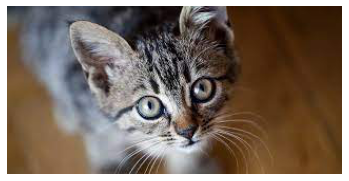

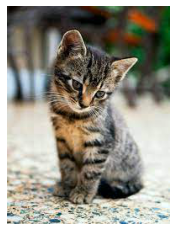

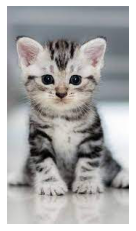

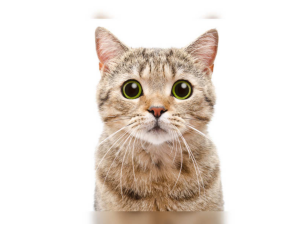

In [27]:
for im_path in os.listdir(path_to_images)[:3]:
    im = Image.open(os.path.join(path_to_images, im_path))
    plt.imshow(im)
    plt.axis('off')
    plt.show()

## Let's train a model ...

In [30]:
config = TrainingConfig(
    output_dir='my_model',
    train_early_stopping=50,
    learning_rate=1e-5, # Since data is of high dimension decrease the learning rate to avoid nan 
    batch_size=200, # Set to 200 for demo purposes to speed up (default: 50)
    max_epochs=200 # Set to 200 for demo purposes. Augment this in your case (default: 20000)
)

In [31]:
torch.manual_seed(8)
pipeline = TrainingPipeline(training_config=config)
pipeline(train_data=path_to_images, log_output_dir='output_logs')

Data of different shapes detected !
 -> Reshaped data to minimum size (data of shape: (4, 3, 159, 168)).
Data normalized!
 -> If this is not hte desired behavior pass an instance set the data_normalization attribute of DataProceor instance to False
Model passed sanity check !

Created my_model/training_2021-06-29_16-01-19. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !
----------------------------------
Training ended!
Saved final model in my_model/training_2021-06-29_16-01-19/final_model


## ... and generate new data

In [32]:
from pyraug.models import RHVAE
from pyraug.models.rhvae import RHVAESamplerConfig
last_training = sorted(os.listdir('my_model'))[-1]
model = RHVAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [35]:
generation_pipe = GenerationPipeline(
    model=model
)
generation_pipe(10)

Created dummy_output_dir/generation_2021-06-29_16-04-00.Generated data and sampler config will be saved here.

Generation successfully launched !



In [37]:
last_generation = sorted(os.listdir('dummy_output_dir'))[-1]
generated_data = torch.load(os.path.join('dummy_output_dir', last_generation, 'generated_data_10_0.pt'))

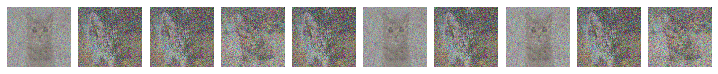

In [42]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 0
for i in range(10):
        
                axes[i].matshow(np.moveaxis(generated_data[i].cpu().reshape(3, 159, 168).numpy(), 0, 2), cmap='gray')
                axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [59]:
for i in range(len(dataset_to_augment)):
    for j in range(len(generated_data)):
        assert notorch.equal(generated_data[j].cpu(), torch.tensor(dataset_to_augment[i]).cpu().type(torch.float)), (i, j)

AssertionError: (0, 0)

In [55]:
 torch.tensor(dataset_to_augment[j]).cpu()

tensor([[[164, 206,  84],
         [105, 140,  61],
         [118, 148, 101],
         ...,
         [109, 147,  73],
         [108, 147,  69],
         [ 91, 129,  57]],

        [[167, 213,  84],
         [116, 160,  49],
         [ 72, 109,  43],
         ...,
         [105, 142,  79],
         [105, 142,  72],
         [ 89, 127,  57]],

        [[140, 191,  65],
         [142, 193,  66],
         [119, 163,  79],
         ...,
         [104, 139,  84],
         [ 84, 120,  58],
         [ 78, 115,  49]],

        ...,

        [[139, 148,  81],
         [142, 155,  74],
         [135, 156,  72],
         ...,
         [ 89, 134,  28],
         [ 97, 148,  24],
         [126, 176,  49]],

        [[163, 157,  85],
         [153, 164,  82],
         [146, 164,  90],
         ...,
         [ 85, 130,  19],
         [ 98, 148,  27],
         [127, 178,  48]],

        [[183, 153, 102],
         [176, 182, 116],
         [154, 154, 100],
         ...,
         [ 94, 134,  29],
        

In [49]:
len(dataset_to_augment)

200

In [8]:
from pyraug.models.rhvae.rhvae_sampler import RHVAESampler, RHVAESamplerConfig

In [9]:
sampler = RHVAESampler(model, RHVAESamplerConfig())

tensor([[-0.5985,  1.1016,  1.5223,  ...,  1.3661, -3.3497, -2.3714],
        [-1.7094,  0.9256, -0.8169,  ..., -0.3815, -0.6951, -2.3005],
        [-1.7986,  1.1095,  0.0925,  ...,  1.4927, -1.7740, -2.2956],
        ...,
        [ 0.3662,  1.6328, -0.7616,  ..., -1.2705, -3.9515, -1.3101],
        [-0.7977,  1.3706, -0.9864,  ..., -0.1350, -2.6551, -1.6866],
        [-0.3779,  0.6218,  0.6110,  ...,  2.7358, -2.6942, -1.7261]],
       device='cuda:0')
tensor([[[ 6.4326e-01,  1.2422e-02,  2.9660e-02,  ...,  2.2557e-02,
          -2.0099e-03,  6.1290e-02],
         [ 1.2422e-02,  6.5083e-01, -1.5031e-02,  ..., -1.6493e-02,
           3.1493e-02, -2.9597e-02],
         [ 2.9660e-02, -1.5031e-02,  5.6491e-01,  ..., -2.1869e-02,
          -2.2422e-02, -2.2353e-02],
         ...,
         [ 2.2557e-02, -1.6493e-02, -2.1869e-02,  ...,  6.3957e-01,
          -4.6333e-02,  3.0891e-02],
         [-2.0099e-03,  3.1493e-02, -2.2422e-02,  ..., -4.6333e-02,
           7.1043e-01, -1.8424e-02],
   

In [173]:
RHVAEConfig.from_json_file('../scripts/configs/rhvae_config.json')

RHVAEConfig(input_dim=None, latent_dim=10, uses_default_encoder=True, uses_default_decoder=True, n_lf=3, eps_lf=0.001, beta_zero=0.3, temperature=1.5, regularization=0.01, uses_default_metric=True)

In [174]:
TrainingConfig.from_json_file('../scripts/configs/training_config.json')

TrainingConfig(output_dir=None, batch_size=50, max_epochs=200, learning_rate=0.001, train_early_stopping=50, eval_early_stopping=None, steps_saving=1000, seed=8, no_cuda=False, verbose=True)

In [176]:
RHVAESamplerConfig.from_json_file('../scripts/configs/rhvae_sampler_config.json')

RHVAESamplerConfig(output_dir='my_generated_data', batch_size=50, samples_per_save=500, no_cuda=False, mcmc_steps_nbr=100, n_lf=15, eps_lf=0.03, beta_zero=1.0)

In [10]:
sampler.sample(2)

In [116]:
for i in range(30, 200):
    for j in range(i+1, 200):
        assert not torch.equal(model.centroids_tens[i], model.centroids_tens[j]), (i, j)

AssertionError: (30, 31)

In [16]:
model.G_inv(torch.randn(10, 10).cuda())

RuntimeError: ignored

In [14]:
sampler.m

Parameter containing:
tensor([1.5000], device='cuda:0')

RuntimeError: ignored

Let's have a look to the generated samples

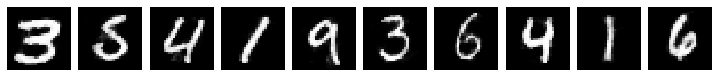

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 20
for i in range(10):
        axes[i].matshow(generated_data[im_n+i].cpu().reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

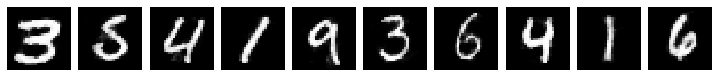

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 20
for i in range(10):
        axes[i].matshow(generated_data[im_n+i].cpu().reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [ ]:
dataset_to_augment.max()

tensor(255, dtype=torch.uint8)

In [ ]:
import torch.nn as nn
from pyraug.models.base_architectures import Base_Encoder

In [ ]:
class Encoder_Conv(Base_Encoder):
    def __init__(self):
        Base_Encoder.__init__(self)
        self.input_dim = 784
        self.latent_dim = 10
        self.n_channels = 1

        self.layers = nn.Sequential(
            nn.Conv2d(
                self.n_channels, out_channels=32, kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.fc1 = nn.Sequential(nn.Linear(512, 400), nn.ReLU())

        self.mu = nn.Linear(400, self.latent_dim)
        self.std = nn.Linear(400, self.latent_dim)

    def forward(self, x):
        out = self.layers(
            x.reshape(
                -1, self.n_channels, int(x.shape[-1] ** 0.5), int(x.shape[-1] ** 0.5)
            )
        )
        out = self.fc1(out.reshape(x.shape[0], -1))
        return self.mu(out), self.std(out)

In [ ]:
custom_enc = Encoder_Conv()

In [ ]:
dataset_to_augment.shape

torch.Size([200, 28, 28])

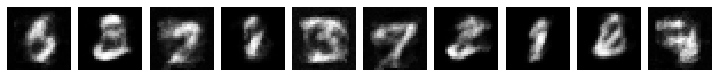

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
        axes[i].matshow(generated_data[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [ ]:
from pyraug.augmentation import train_my_model

In [ ]:
train_my_model()

In [ ]:
model = train_my_model(data=dataset_to_augment, encoder=custom_enc, outputs/a)

Launching augmentation. Logs will be save in 'outputs'

No training_config provided. Using default.

No model_config provided. Using default.

No decoder architecture provided. Using default.

No metric architecture provided. Using default.

Created dummy_recording/training_2021-06-04_12-03-25
Creating dummy_recording/training_2021-06-04_12-03-25. Repo will be deleted at the end of training

RHVAE(
  (encoder): Encoder_Conv(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

dummy_recording/training_2021-06-04_12-03-25/encoder.pkl


In [ ]:
from pyraug.augmentation import augment_from_pretrained

In [ ]:
generated_data = augment_from_pretrained(
    model=model,
    number_of_samples=100
    )

No generation_config provided. Using default.

Launching generation !



Initializing to centroids
Initializing to centroids


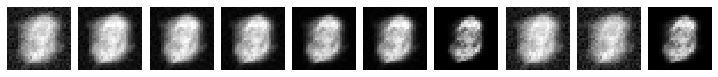

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
        axes[i].matshow(generated_data[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [22]:
RHVAE.load_from_folder('../outputs/my_model_from_script/training_2021-06-22_17-07-54/final_model')

RHVAE(
  (encoder): Encoder_MLP_High(
    (layers): Sequential(
      (0): Linear(in_features=3072, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=400, bias=True)
    )
    (mu): Linear(in_features=400, out_features=10, bias=True)
    (std): Linear(in_features=400, out_features=10, bias=True)
  )
  (decoder): Decoder_MLP(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=3072, bias=True)
      (3): Sigmoid()
    )
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=3072, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=10, bias=True)
    (lower): Linear(in_features=400, out_features=45, bias=True)
  )
)

In [21]:
ls ../outputs/my_model_from_script/training_2021-06-22_17-07-54/

final_model/


In [24]:
torch.load('../outputs/my_generated_data_from_script/generation_2021-06-22_17-19-01/generated_data_10_0.pt').shape

torch.Size([10, 3072])

In [ ]:
model(dataset_to_augment.type(torch.float) /255.+0.0001)

(tensor([[0.0062, 0.0043, 0.0065,  ..., 0.0066, 0.0051, 0.0052],
         [0.0173, 0.0251, 0.0184,  ..., 0.0249, 0.0204, 0.0205],
         [0.0280, 0.0151, 0.0205,  ..., 0.0212, 0.0309, 0.0245],
         ...,
         [0.0062, 0.0119, 0.0058,  ..., 0.0128, 0.0063, 0.0066],
         [0.0301, 0.0265, 0.0225,  ..., 0.0370, 0.0208, 0.0271],
         [0.0206, 0.0126, 0.0156,  ..., 0.0165, 0.0245, 0.0168]],
        grad_fn=<SigmoidBackward>),
 tensor([[-1.1522, -0.1244, -2.1099,  ...,  2.2233, -0.6844,  2.2815],
         [ 0.1115,  0.2182, -1.9760,  ...,  0.9631,  0.7458,  1.0231],
         [-0.0588, -0.1437,  0.5366,  ...,  1.9954,  1.4945,  0.8236],
         ...,
         [ 0.9263, -1.6631, -1.9265,  ...,  0.1140,  0.0434, -0.7371],
         [-1.4952, -0.3787, -0.9741,  ...,  1.1608,  0.3417, -0.7760],
         [-0.4344, -1.0094,  2.6459,  ..., -0.8406, -0.2104,  2.4245]],
        grad_fn=<AddBackward0>),
 tensor([[-1.1458, -0.1371, -2.1004,  ...,  2.2251, -0.6747,  2.2803],
         [ 0.1

In [ ]:
model.model_con

False

In [ ]:
torch.tensor([[1, 2, ], [1, 9, 0]])

ValueError: expected sequence of length 2 at dim 1 (got 3)

In [ ]:
t = torch.tensor([1])

In [ ]:
issubclass(t.type, np.integer)

TypeError: issubclass() arg 1 must be a class

In [ ]:
from dataset import AutoDatasetsArguments

In [ ]:
auto = AutoDatasetsArguments(demo_dataset='mnist')

Loading mnist demo ...


/home/clement/Documents/these/implem/software/dataset.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data).type(torch.float)
/home/clement/Documents/these/implem/software/dataset.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets).type(torch.long)


In [ ]:
auto.data.shape, auto.targets

(torch.Size([500, 784]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
   

In [ ]:
from model import ModelArguments

In [ ]:
model = ModelArguments(latent_dim=3.)

TypeError: The field `latent_dim` was assigned by `<class 'float'>` instead of `<class 'int'>`

In [ ]:
help(ModelArguments)

Help on class ModelArguments in module model:

class ModelArguments(basetyping.TypingChecker)
 |  ModelArguments(latent_dim: int = 2) -> None
 |  
 |  ModelArguments(latent_dim: int = 2)
 |  
 |  Method resolution order:
 |      ModelArguments
 |      basetyping.TypingChecker
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |  
 |  __init__(self, latent_dim: int = 2) -> None
 |  
 |  __repr__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'latent_dim': <class 'int'>}
 |  
 |  __dataclass_fields__ = {'latent_dim': Field(name='latent_dim',type=<cl...
 |  
 |  __dataclass_params__ = _DataclassParams(init=True,repr=True,eq=True,or...
 |  
 |  __hash__ = None
 |  
 |  latent_dim = 2
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from basetyping.TypingChecker:
 |  
 |  __post_init__(self)
 |  

In [ ]:
m = ModelArguments(latent_dim=3)

Check is passed successfully


In [ ]:
m

ModelArguments(latent_dim=3)